# EMG 資料處理教學
## 載入package

In [1]:
import pandas as pd #處理資料結構用
import numpy as np #矩陣運算
import matplotlib.pyplot as plt #繪圖
from scipy.fft import fft #訊號處理：傅立葉轉換
from scipy import signal # 訊號處理: 濾波...等
import pyfftw #傅立葉轉換

## 讀取資料

- **設定資料路徑**
- **讀資料**: 使用 pandas package 讀取 ".CSV" 資料
- **選取資料位點**

In [2]:
file_path = r'F:\HsinYang\NTSU\TenLab\Shooting\Wu_EMG\RawData\sensor1\01_Lai\shooting\Run_number_32_Shooting_Rep_1.2.csv'
data = pd.read_csv(file_path
                   ,encoding='UTF-8')
# 選取資料位點
data_time = data.iloc[:, 0]
EMG_data = data['Trigno sensor 1: EMG 1']

## 設定資料參數

- **資料長度**
- **取樣頻率**
- **取樣週期**

In [3]:
# determin the data length
# 計算資料長度
N = int(np.prod(data_time.shape))#length of the array
N2 = 2**(N.bit_length()-1) #last power of 2
# calculate the sampling rate
# 計算取樣頻率
Fs = 1/(data_time[1]-data_time[0])  #sample rate (Hz)
# convert sampling rate to period
# 計算取樣週期
T = 1/Fs;
print("# Samples length:",N)
print("# Sampling rate:",Fs)

# Samples length: 36000
# Sampling rate: 2000.0


## 原始資料繪圖

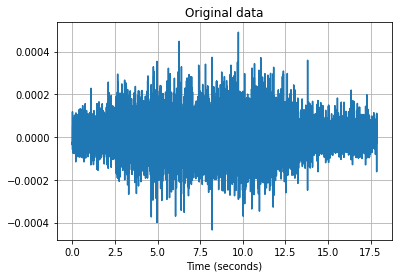

In [4]:
plt.figure(1)  
fig1 = plt.figure(1)
plt.plot(data_time, EMG_data)
plt.xlabel('Time (seconds)')
plt.title('Original data')
plt.grid()
plt.show()

## 資料前處理
![EMG spectral Density](./EMG_SpectralDensity.png)
- **帶通濾波 (Bandpass filter)**: 去除動作偽影(Motion Artiface) 以及雜訊
- **濾波器選擇**: Butterworth
For a Butterworth filter, this is the point at which the gain drops to 1/sqrt(2) that of the passband (the “-3 dB point”).

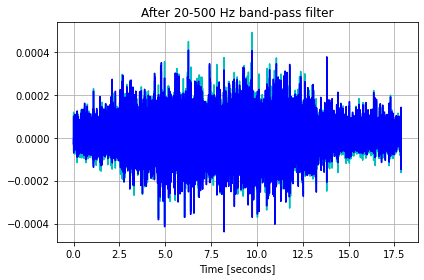

In [5]:
bandpass_sos = signal.butter(2, [20, 500],  btype='bandpass', fs=Fs, output='sos')
bandpass_filtered_1 = signal.sosfilt(bandpass_sos, EMG_data)
bandpass_filtered_2 = signal.sosfiltfilt(bandpass_sos, EMG_data)

# plot the signal after filter
plt.figure(2)
plt.plot(data_time, EMG_data, color='c')
plt.plot(data_time, bandpass_filtered_1, color='b')
# plt.plot(Data_time, bandpass_filtered_2, color='r')
plt.title('After 20-500 Hz band-pass filter')
plt.xlabel('Time [seconds]')
plt.tight_layout()
plt.grid()
plt.show()

## 資料平滑化處理

- **低通濾波器**
- **移動均方根**

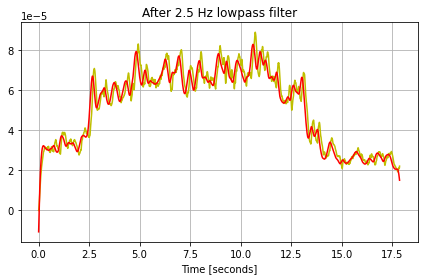

In [6]:
# 取絕對值
abs_data_1 = abs(bandpass_filtered_1)
abs_data_2 = abs(bandpass_filtered_2)

# 設定低通濾波器參數
lowpass_sos = signal.butter(2, 2.5, btype='low', fs=Fs, output='sos')
lowpass_filtered_1 = signal.sosfilt(lowpass_sos, abs_data_1)
lowpass_filtered_2 = signal.sosfiltfilt(lowpass_sos, abs_data_2)

# plot the signal after filter
plt.figure(3)
#fig3 = plt.figure(3)
#fig3.set_size_inches(12, 8)
# plt.plot(Data_time, EMG_data)
plt.plot(data_time, lowpass_filtered_1, color='y')
plt.plot(data_time, lowpass_filtered_2, color='r')
plt.title('After 2.5 Hz lowpass filter')
plt.xlabel('Time [seconds]')
plt.tight_layout()
plt.grid()
plt.show()

## 頻域分析

- **傅立葉轉換**:

![FourierTransform](./FourierTransform.gif)

> **更深入了解**: [圖解傅立葉分析](https://hackmd.io/@sysprog/fourier-transform)，[可視化的傅里葉變換](https://www.youtube.com/watch?v=spUNpyF58BY&t=11s)，[The Fast Fourier Transform (FFT)](https://www.youtube.com/watch?v=E8HeD-MUrjY)

<Figure size 432x288 with 0 Axes>

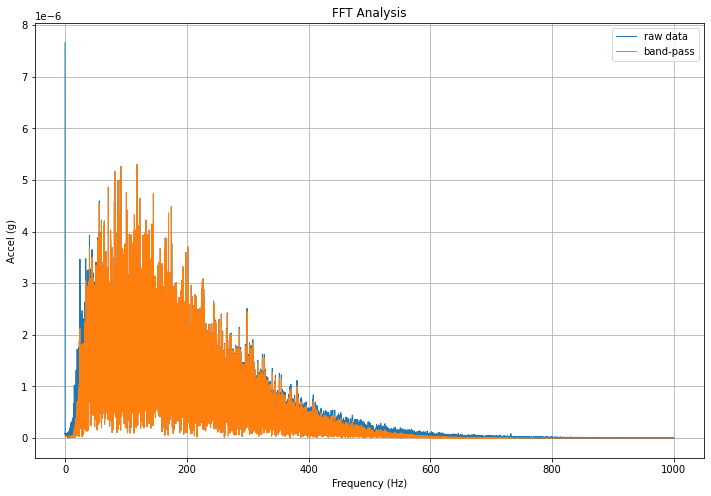

In [7]:
# 計算傅立葉轉換
# frequency only half of sampling rate, due to complex part of numerical
N = N2 #truncate array to the last power of 2
xf = np.linspace(0.0, np.ceil(1.0/(2.0*T)), N//2)
# due to our data type is series, therefore we need to extract value in the series
yf = fft(EMG_data.values)
yf1 = fft(bandpass_filtered_2)
bandpass_filtered_2
# plot the figure
plt.figure(4)
fig4 = plt.figure(2)
fig4.set_size_inches(12, 8)
# normalize
plt.plot(xf, 2.0/N * abs(yf[0:int(N/2)]), linewidth = 1, label = 'raw data')
plt.plot(xf, 2.0/N * abs(yf1[0:int(N/2)]), linewidth = 1, label = 'band-pass')
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Accel (g)')
plt.title('FFT Analysis')
plt.legend()
plt.show()


## 濾波器設計

- **決定濾波區間**

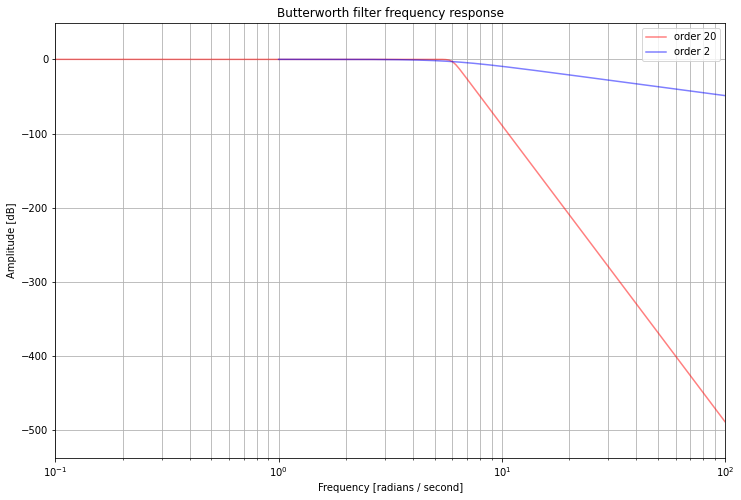

In [9]:
# check bandpass filter shape
# bandpass filter and plot its frequency response
b, a = signal.butter(20, 6,  btype='low', analog=True)
w, h = signal.freqs(b, a)

b1, a1 = signal.butter(2, 6,  btype='low', analog=True)
w1, h1 = signal.freqs(b1, a1)

# plot the Butterworth filter frequency response figure

plt.figure(5)
fig5 = plt.figure(5)
fig5.set_size_inches(12, 8)
plt.plot(w, 20 * np.log10(abs(h)), label = 'order 20', color = 'r', alpha = 0.5)
plt.plot(w1, 20 * np.log10(abs(h1)), label = 'order 2', color= 'b', alpha = 0.5)
plt.semilogx()
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.legend()
plt.show()

## 濾波器設計

- **消除time delay**

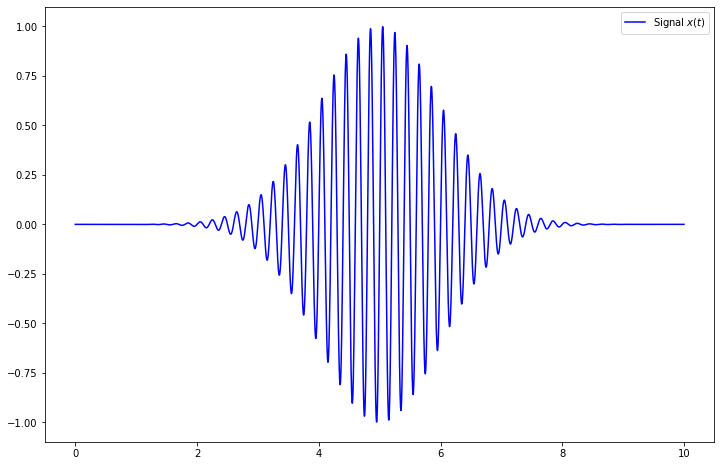

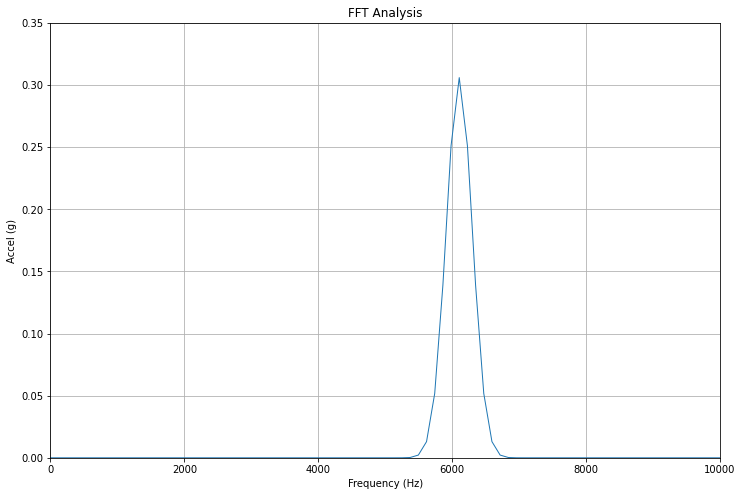

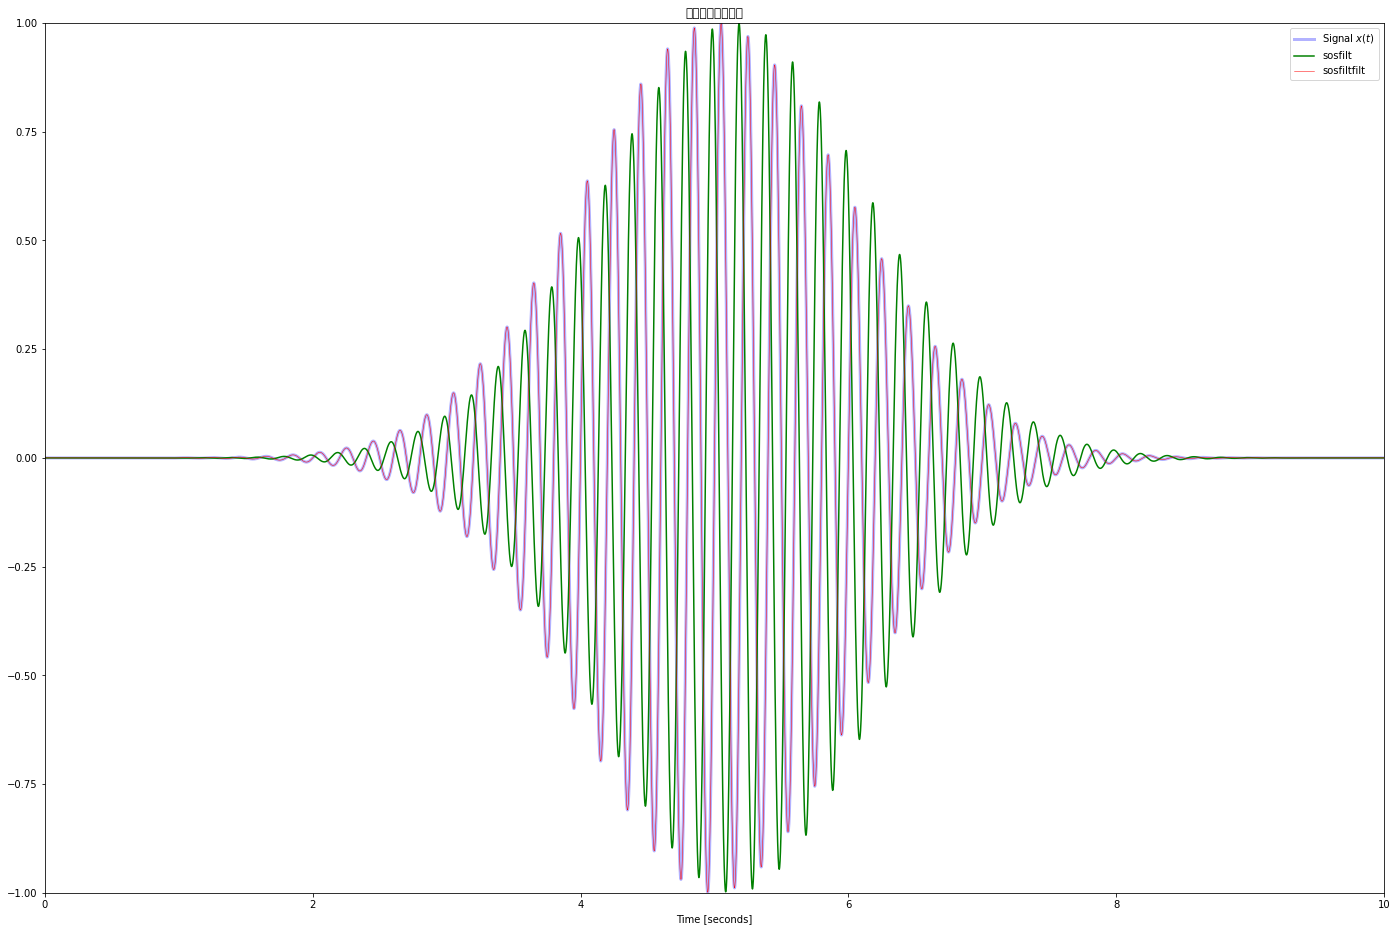

In [11]:
f0 = 1e4 
Fs = 1e6
T = 1e-2
f1 = 5e3 
t = np.arange(0, T, 1/Fs)
# 創建資料
envelope = np.exp(-5e5*(t-T/2)**2)
sig2 = envelope * np.sin(2*np.pi*f1*t)
# 繪圖
plt.figure(6)
fig6 = plt.figure(6)
fig6.set_size_inches(12, 8)
plt.plot(t*1000, sig2, label='Signal $x(t)$', color = 'b')
plt.legend()
plt.show()

# 傅立葉轉換
# frequency only half of sampling rate, due to complex part of numerical
N = int(np.prod(sig2.shape))#length of the array
N2 = 2**(N.bit_length()-1) #last power of 2
N = N2 #truncate array to the last power of 2
T = 1/Fs

xf = np.linspace(0.0, np.ceil(1.0/(2.0*T)), N//2)
pyfftw.forget_wisdom()
fft_obj = pyfftw.builders.rfft(sig2)
# due to our data type is series, therefore we need to extract value in the series
yf = fft(sig2)

# 繪圖
plt.figure(7)
fig7 = plt.figure(7)
fig7.set_size_inches(12, 8)
# normalize
plt.plot(xf, 2.0/N * abs(yf[0:int(N/2)]), linewidth = 1, label = 'fft')
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Accel (g)')
plt.title('FFT Analysis')
plt.axis([0, 10000, 0, 0.35])
plt.show()

# 低通濾波 8000Hz
# 分別使用filt與filtfilt函數
sos = signal.butter(10, 8000, 'low', fs=Fs, output='sos')
filtered_4 = signal.sosfilt(sos, sig2)
filtered_3 = signal.sosfiltfilt(sos, sig2)
# 繪圖
plt.figure(8)
fig8 = plt.figure(8)
fig8.set_size_inches(24, 16)
plt.plot(t*1000, sig2, label='Signal $x(t)$', linewidth = 3, color = 'b', alpha=0.3)
plt.plot(t*1000, filtered_4, label='sosfilt', color='g')
plt.plot(t*1000, filtered_3, label='sosfiltfilt', linewidth = 0.5, color='r')
# ax2.plot(t, filtered_1, color = 'r')
plt.title('不同濾波器之差異')
plt.axis([0, 10, -1, 1])
plt.xlabel('Time [seconds]')
plt.legend()